Initializing Generator on cpu...
Using random weights.


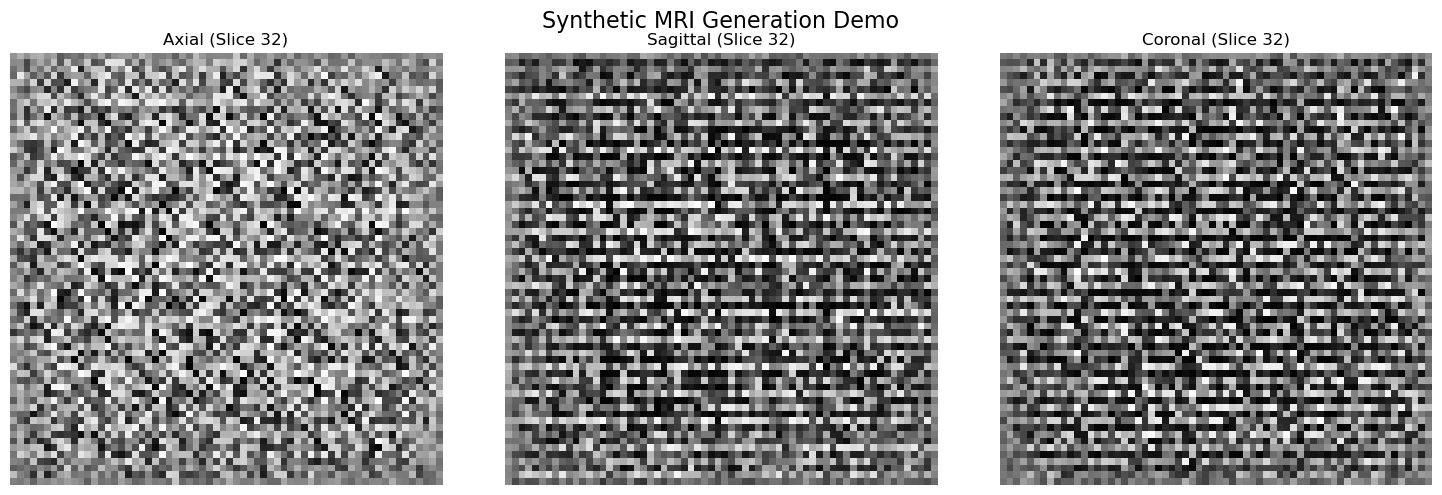

Visualization complete. Volume shape: (64, 64, 64)


In [2]:
# -*- coding: utf-8 -*-
"""
Author: Teresa Zorzi
Date: January 2026
Description: Demo Notebook to generate and visualize synthetic MRI brain scans.
"""

import os
import sys
import glob
import torch
import matplotlib.pyplot as plt

# --- PATH SETUP ---
# Determine project root relative to this notebook to ensure imports work
# regardless of where the notebook is stored.
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))

if project_root not in sys.path:
    sys.path.append(project_root)

# Import strictly after path setup
try:
    from src.models import CPUOptimizedGenerator3D
except ImportError:
    raise ImportError(
        f"Could not import 'src'. Ensure the project root is correct: {project_root}"
    )

%matplotlib inline


def load_latest_checkpoint(model, checkpoint_dir_rel):
    """
    Search for the latest .pth file in the checkpoint directory and load it.

    Parameters
    ----------
    model : torch.nn.Module
        The neural network model instance to populate.
    checkpoint_dir_rel : str
        Path to the checkpoints directory relative to the project root.

    Returns
    -------
    torch.nn.Module
        The model with loaded weights (or random weights if no checkpoint found).
    """
    # Build absolute path to avoid ambiguity
    full_checkpoint_dir = os.path.join(project_root, checkpoint_dir_rel)
    
    if not os.path.exists(full_checkpoint_dir):
        print(f"Warning: Directory not found: {full_checkpoint_dir}")
        print("Using random weights (output will be noise).")
        return model

    list_of_files = glob.glob(os.path.join(full_checkpoint_dir, '*.pth'))
    
    if not list_of_files:
        print("Warning: No .pth checkpoints found.")
        print("Using random weights.")
        return model

    latest_file = max(list_of_files, key=os.path.getctime)
    
    print(f"Loading weights from: {os.path.basename(latest_file)}")
    
    try:
        # map_location='cpu' ensures the demo runs on any machine (even without GPU)
        model.load_state_dict(torch.load(latest_file, map_location=torch.device('cpu')))
        print("Weights loaded successfully.")
    except Exception as e:
        print(f"Error loading weights: {e}")
    
    return model


def show_generated_brain(latent_dim=64):
    """
    Generate a random 3D MRI volume and visualize its orthogonal slices.

    Parameters
    ----------
    latent_dim : int, optional
        Dimension of the latent vector z (must match training config).
    """
    device = torch.device("cpu")
    print(f"Initializing Generator on {device}...")

    netG = CPUOptimizedGenerator3D(latent_dim=latent_dim).to(device)
    
    # Load weights using the relative path expected by the project structure
    netG = load_latest_checkpoint(netG, os.path.join("results", "checkpoints"))
    netG.eval() 
    
    z = torch.randn(1, latent_dim).to(device) 
    # Use Class 0 (e.g., AD) as a standard example
    fake_label = torch.tensor([0], dtype=torch.long).to(device) 
    
    with torch.no_grad():
        # Squeeze removes batch and channel dimensions -> (Depth, Height, Width)
        fake_brain = netG(z, fake_label).squeeze().numpy() 
    
    depth, height, width = fake_brain.shape
    mid_d, mid_h, mid_w = depth // 2, height // 2, width // 2

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Axial View
    axes[0].imshow(fake_brain[mid_d, :, :], cmap='gray')
    axes[0].set_title(f"Axial (Slice {mid_d})")
    axes[0].axis('off')
    
    # Sagittal View
    axes[1].imshow(fake_brain[:, mid_h, :], cmap='gray')
    axes[1].set_title(f"Sagittal (Slice {mid_h})")
    axes[1].axis('off')
    
    # Coronal View
    axes[2].imshow(fake_brain[:, :, mid_w], cmap='gray')
    axes[2].set_title(f"Coronal (Slice {mid_w})")
    axes[2].axis('off')
    
    plt.suptitle("Synthetic MRI Generation Demo", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    print(f"Visualization complete. Volume shape: {fake_brain.shape}")

# Entry point
if __name__ == "__main__":
    show_generated_brain()